<a href="https://colab.research.google.com/github/singwang-cn/Neural-Network/blob/master/neural_network_for_lecture.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import struct
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def load_image(datafile=''):
  path = '/content/drive/My Drive/Dataset/mnist dataset/'+datafile
  data = open(path, 'rb').read()
  magic_number, num_image, num_row, num_col = struct.unpack_from('>iiii', data, 0)
  offset = 16
  image_list = []
  for i in range(num_image):
    image = np.array(struct.unpack_from('>'+str(num_row*num_col)+'B', data, offset)).reshape(num_row,num_col)
    image_list.append(image)
    offset += int(num_row*num_col)
  return image_list

def load_label(datafile=''):
  path = '/content/drive/My Drive/Dataset/mnist dataset/'+datafile
  data = open(path, 'rb').read()
  magic_number, num_label = struct.unpack_from('>ii', data, 0)
  offset = 8
  label_list = []
  for i in range(num_label):
    label = struct.unpack_from('>B', data, offset)
    label_list.append(label[0])
    offset += 1
  return label_list

image = load_image('t10k-images.idx3-ubyte')
label = load_label('t10k-labels.idx1-ubyte')

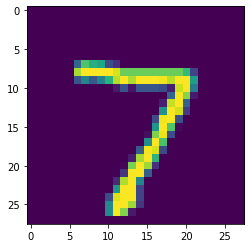

In [ ]:
plt.imshow(image[0])

In [ ]:
def sigmoid(x):
  return 1.0 / (1.0 + np.exp(-x))

In [ ]:
def relu(x):
  return np.maximum(0, x)

In [ ]:
def softmax(a):
  c = np.max(a)
  e_a = np.exp(a-c)
  sum_e_a = np.sum(e_a)
  return e_a / sum_e_a

In [ ]:
'''
def cross_entropy_error(y, y_hat):
  d = 1e-7
  if y.ndim==1:
    y = y.reshape(1,y.size)
  n = y.shape[0]

  return -np.sum(np.log(y[np.arange(n),y_hat]+d)) / n
'''

In [ ]:
def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
        
    # 教師データがone-hot-vectorの場合、正解ラベルのインデックスに変換
    if t.size == y.size:
        t = t.argmax(axis=1)
             
    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size

In [ ]:
def gradient(func, x):
  h = 1e-4
  grad = np.zeros_like(x)
  if x.ndim==1:
    for i in range(x.size):
      x_i = x[i]
      x[i] = x_i-h
      y_l = func(x)
      x[i] = x_i+h
      y_r = func(x)
      grad[i] = (y_r-y_l) / (2*h)
      x[i] = x_i
  else:
    for i in range(x.shape[0]):
      for j in range(x.shape[1]):
        x_ij = x[i][j]
        x[i][j] = x_ij-h
        y_l = func(x)
        x[i][j] = x_ij+h
        y_r = func(x)
        grad[i][j] = (y_r-y_l) / (2*h)
        x[i][j] = x_ij
  return grad

In [ ]:
def _numerical_gradient_1d(f, x):
    h = 1e-4 # 0.0001
    grad = np.zeros_like(x)
    
    for idx in range(x.size):
        tmp_val = x[idx]
        x[idx] = float(tmp_val) + h
        fxh1 = f(x) # f(x+h)
        
        x[idx] = tmp_val - h 
        fxh2 = f(x) # f(x-h)
        grad[idx] = (fxh1 - fxh2) / (2*h)
        
        x[idx] = tmp_val # 値を元に戻す
        
    return grad


def numerical_gradient_2d(f, X):
    if X.ndim == 1:
        return _numerical_gradient_1d(f, X)
    else:
        grad = np.zeros_like(X)
        
        for idx, x in enumerate(X):
            grad[idx] = _numerical_gradient_1d(f, x)
        
        return grad


def numerical_gradient(f, x):
    h = 1e-4 # 0.0001
    grad = np.zeros_like(x)
    
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        idx = it.multi_index
        tmp_val = x[idx]
        x[idx] = tmp_val + h
        fxh1 = f(x) # f(x+h)
        
        x[idx] = tmp_val - h 
        fxh2 = f(x) # f(x-h)
        grad[idx] = (fxh1 - fxh2) / (2*h)
        
        x[idx] = tmp_val # 値を元に戻す
        it.iternext()   
        
    return grad

In [ ]:
def gradient_descent(func, x_i, lr=0.01, step=100):
  x = x_i
  for i in range(step):
    g = gradient(func, x)
    x -= lr*g
  return x

In [ ]:
class neural_network():
  def __init__(self, input_size, hidden_size, output_size, weight_init=0.01):
    self.parameters = {}
    self.parameters['w1'] = weight_init * np.random.rand(input_size, hidden_size)
    self.parameters['b1'] = np.zeros(hidden_size)
    self.parameters['w2'] = weight_init * np.random.rand(hidden_size, output_size)
    self.parameters['b2'] = np.zeros(output_size)

  def recognize(self, x):
    w1,w2 = self.parameters['w1'],self.parameters['w2']
    b1,b2 = self.parameters['b1'],self.parameters['b2']
    x = x /255
    a1 = np.dot(x,w1) + b1
    z = sigmoid(a1)
    a2 = np.dot(z,w2) + b2
    y = a2
    
    return y

  def cost_function(self, x, label):
    y = self.recognize(x)
    print(y)
    d = 1e-7
    cee = -np.log(y[label]+d)

    return cee
  
  def gradient(self, x, label):
    h = 1e-4
    grads = {}
    for key in ('w1','b1','w2','b2'):
      grads[key] = np.zeros(self.parameters[key].size)
      index = 0
      for p in self.parameters[key]:
        p_value = p
        p = p_value+h
        loss_p = self.cost_function(x, label)
        p = p_value-h
        loss_n = self.cost_function(x, label)
        p = p_value
        grads[key][index] = (loss_p-loss_n) / (2*h)
        index += 1
      grads[key].reshape(self.parameters[key].shape)

    return grads

  

In [ ]:
nn = neural_network(784, 100, 10)

In [ ]:
nn.recognize(image[0].flatten())

array([0.29750184, 0.3261874 , 0.28727075, 0.31427634, 0.31290784,
       0.30062749, 0.29924688, 0.30684649, 0.33228438, 0.30851027])

In [ ]:
nn.cost_function(image[0].flatten(),5)

[0.29750184 0.3261874  0.28727075 0.31427634 0.31290784 0.30062749
 0.29924688 0.30684649 0.33228438 0.30851027]


1.2018830286576763

In [ ]:
nn.parameters['w1'][350]

array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1,
       0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1,
       0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1,
       0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1,
       0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1,
       0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1,
       0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1,
       0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])

In [ ]:
nn.parameters['w1'] = np.zeros([784, 100])

In [ ]:
nn.recognize(image[0].flatten())

array([0.25247878, 0.27667957, 0.24387259, 0.26651131, 0.26535459,
       0.25495241, 0.25386842, 0.26024972, 0.28207146, 0.26171552])

In [ ]:
nn.cost_function(image[0].flatten(),5)

[0.10013786 0.09855312 0.10185665 0.10037016 0.09945078 0.09916065
 0.09922217 0.09963029 0.1007471  0.10087121]


2.3110130403974822

In [ ]:
nn.gradient(image[0].flatten(),5)

In [ ]:
nn = neural_network(784, 100, 10)
loss_list = []
for i in range(1):
  grad = nn.gradient(image[i].flatten(), np.array([label[i]]))
  for key in ('w1','b1','w2','b2'):
    nn.parameters[key] -= 0.1*grad[key]

  loss = nn.cost_function(image[i].flatten(), np.array([label[i]]))
  loss_list.append(loss)


In [ ]:
loss_list

In [ ]:
v = np.random.rand(5)
w1 = np.matrix(np.random.rand(5,1))
w2 = np.matrix(np.random.rand(5,1))

a = (v * w1)
w1[0][0] += 0.001
b = (v * w1)



  

In [ ]:
a-b

matrix([[-0.00057428]])